# DATA PREPROCESSING

In [1]:
import pandas as pd

# Load dataset from Windows path (use raw string format)
df = pd.read_csv(r"C:\Users\91910\Downloads\Systemic Lupus Erythematosus.csv")

# Drop duplicate rows based on 'RA' column
df = df.drop_duplicates(subset='RA', keep='first')

# Map 'Gender' column to numeric values: Male=0, Female=1
df['Gender'] = df['Gender'].map({"Male": 0, "Female": 1})

# Define the binary symptom and treatment columns expected in the dataset
binary_cols = [
    "Fever", "ACL", "CCL", "Oral Ul", "Alopecia", "joint pain", "Serositis",
    "Renal", "Proteinuria", "Neurologic", "Hemolytic Anemia", "Leukopenia", 
    "Thrombocytopenia", "Anti-Nuclear Antibody", "Anti-dsDNA", "Anti-Sm", 
    "Anti-Phospholipid", "Low C3", "Low C4", "Azathioprine", "Hydroxychloroquine",
    "Corticosteroids", "Methotrexate", "Cyclophosphamide", "Mycophenolate Mofetil",
    "Rituximab", "Belimumab"
]

# Function to safely convert values to binary 0 or 1
def convert_binary(val):
    if isinstance(val, str):
        val = val.strip().upper()
        if val in ["Y", "P", "WP", "MP", "LOW"]:
            return 1
        elif val == "N" or val == "0":
            return 0
        else:
            return 0  # Treat all other strings as 0
    elif pd.isnull(val):
        return 0
    try:
        return int(val)
    except (ValueError, TypeError):
        return 0

# Apply conversion to each binary column; if missing, create with zeros
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].apply(convert_binary)
    else:
        df[col] = 0

# Drop all columns ending with 'weight' (redundant feature columns)
weight_cols = [c for c in df.columns if c.lower().endswith('weight')]
df = df.drop(columns=weight_cols)

# Convert 'AGE' and 'age onset' to numeric, coercing errors to NaN
df['AGE'] = pd.to_numeric(df['AGE'], errors='coerce')
df['age onset'] = pd.to_numeric(df['age onset'], errors='coerce')

# Fill missing AGE values with median
df['AGE'] = df['AGE'].fillna(df['AGE'].median())

# Compute median disease duration = AGE - age onset (ignoring NaNs)
median_duration = (df['AGE'] - df['age onset']).median()

# Fill missing 'age onset' values using median duration
df['age onset'] = df['age onset'].fillna(df['AGE'] - median_duration)

# Create new feature 'Disease_Duration'
df['Disease_Duration'] = df['AGE'] - df['age onset']

# Select relevant features including target variable
selected_features = ['RA', 'Gender', 'AGE', 'age onset', 'Disease_Duration'] + binary_cols + ['Classification Score']

df_final = df[selected_features]

sampled_df = df_final.groupby('Classification Score', group_keys=False).apply(
    lambda x: x.sample(min(len(x), 200)), include_groups=False)

# Save to CSV
df_final.to_csv('SLE_preprocessed.csv', index=False)
sampled_df.to_csv('SLE_sampled.csv', index=False)

d:\Users\91910\Documents\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# RANDOM FOREST CLASSIFIER

In [2]:
# RANDOM FOREST CLASSIFIER

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load the dataset (update the path accordingly)
df = pd.read_csv(r"C:\Users\91910\SLE_preprocessed.csv")

# Preview columns and first rows
print(df.columns)
print(df.head())

# Create 'target' column based on 'Classification Score' with threshold 10
threshold = 10
df['target'] = df['Classification Score'].apply(lambda x: 1 if x > threshold else 0)

# Define target column
target_col = 'target'

# Encode categorical features if any
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Prepare features and target
X = df.drop(columns=[target_col, 'Classification Score'], axis=1)
y = df[target_col]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Index(['RA', 'Gender', 'AGE', 'age onset', 'Disease_Duration', 'Fever', 'ACL',
       'CCL', 'Oral Ul', 'Alopecia', 'joint pain', 'Serositis', 'Renal',
       'Proteinuria', 'Neurologic', 'Hemolytic Anemia', 'Leukopenia',
       'Thrombocytopenia', 'Anti-Nuclear Antibody', 'Anti-dsDNA', 'Anti-Sm',
       'Anti-Phospholipid', 'Low C3', 'Low C4', 'Azathioprine',
       'Hydroxychloroquine', 'Corticosteroids', 'Methotrexate',
       'Cyclophosphamide', 'Mycophenolate Mofetil', 'Rituximab', 'Belimumab',
       'Classification Score'],
      dtype='object')
       RA  Gender  AGE  age onset  Disease_Duration  Fever  ACL  CCL  Oral Ul  \
0  RA1001       0   19       12.0               7.0      0    0    0        0   
1  RA1002       1   21       14.0               7.0      0    0    0        0   
2  RA1003       0   21        7.0              14.0      0    0    0        0   
3  RA1004       1   22       10.0              12.0      0    0    0        0   
4  RA1006       1   21        9.0   

d:\Users\91910\Documents\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Users\91910\Documents\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Users\91910\Documents\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


# Confusion matrix for rf_classifier

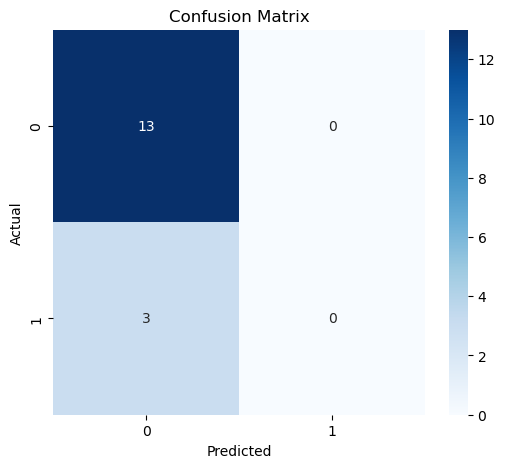

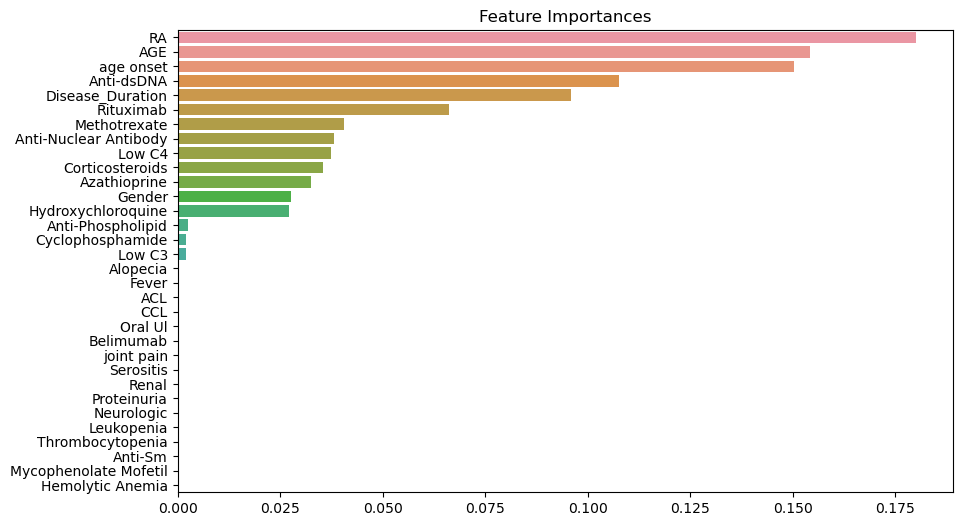

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you already have y_test and y_pred from your code

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot Feature Importances
importances = model.feature_importances_
feature_names = X.columns

# Sort by importance
sorted_idx = importances.argsort()[::-1]
sorted_importances = importances[sorted_idx]
sorted_features = feature_names[sorted_idx]

plt.figure(figsize=(10,6))
sns.barplot(x=sorted_importances, y=sorted_features)
plt.title('Feature Importances')
plt.show()


# Support Vector Machine (SVM)

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Load the preprocessed dataset
df = pd.read_csv(r"C:\Users\91910\SLE_preprocessed.csv")

# Create binary target based on classification score threshold
threshold = 10
df['target'] = df['Classification Score'].apply(lambda x: 1 if x > threshold else 0)
target_col = 'target'

# Encode categorical variables if any
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Separate features and target
X = df.drop(columns=[target_col, 'Classification Score', 'RA'], axis=1)
y = df[target_col]

# Scale features (important for SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Create SVM model
svm_model = SVC(kernel='rbf', random_state=42)

# Train SVM
svm_model.fit(X_train, y_train)

# Predictions
y_pred = svm_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.875

Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93        14
           1       0.00      0.00      0.00         2

    accuracy                           0.88        16
   macro avg       0.44      0.50      0.47        16
weighted avg       0.77      0.88      0.82        16



d:\Users\91910\Documents\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Users\91910\Documents\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Users\91910\Documents\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


# confusion matrix for svm

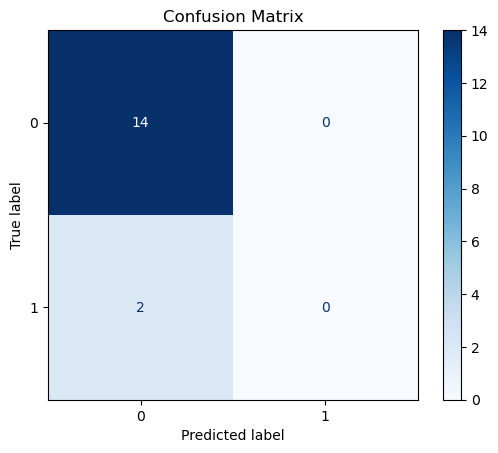

Accuracy: 0.88


d:\Users\91910\Documents\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Users\91910\Documents\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Users\91910\Documents\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


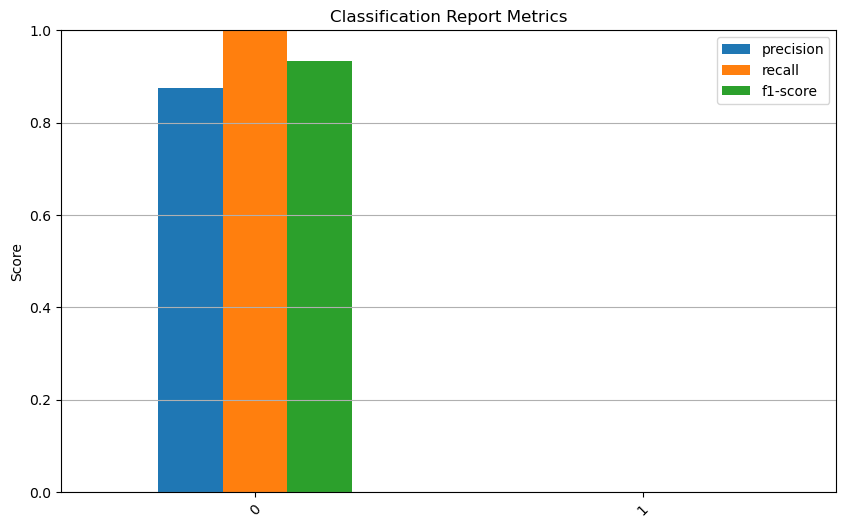

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import seaborn as sns
import pandas as pd

# Assuming you have y_test and y_pred from your model predictions

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix using sklearn's ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Print accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate classification report as a dictionary
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convert classification report to DataFrame for visualization
report_df = pd.DataFrame(report_dict).transpose()

# Plot Precision, Recall and F1-Score per class
metrics_df = report_df.iloc[:-3, :-1]  # Exclude 'accuracy', 'macro avg', 'weighted avg', and 'support' columns if present
metrics_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title('Classification Report Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


# LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier, GaussianNB, GradientBoostingClassifier

--- Logistic Regression ---
Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        14
           1       0.00      0.00      0.00         2

    accuracy                           0.75        16
   macro avg       0.43      0.43      0.43        16
weighted avg       0.75      0.75      0.75        16



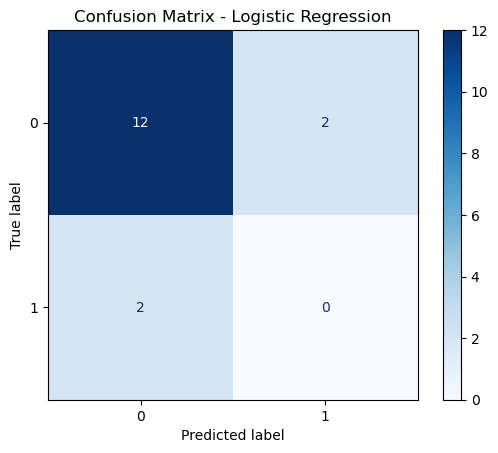

--- Decision Tree ---
Accuracy: 0.625
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        14
           1       0.00      0.00      0.00         2

    accuracy                           0.62        16
   macro avg       0.42      0.36      0.38        16
weighted avg       0.73      0.62      0.67        16



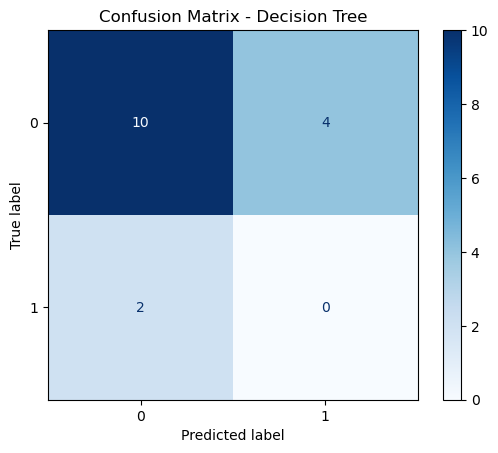

--- K-Nearest Neighbors ---
Accuracy: 0.8125
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        14
           1       0.00      0.00      0.00         2

    accuracy                           0.81        16
   macro avg       0.43      0.46      0.45        16
weighted avg       0.76      0.81      0.78        16



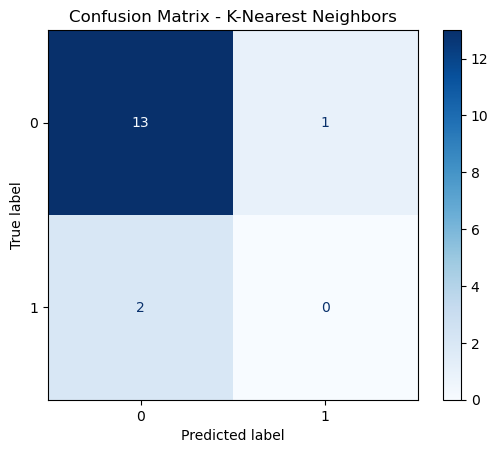

--- Naive Bayes ---
Accuracy: 0.625
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        14
           1       0.00      0.00      0.00         2

    accuracy                           0.62        16
   macro avg       0.42      0.36      0.38        16
weighted avg       0.73      0.62      0.67        16



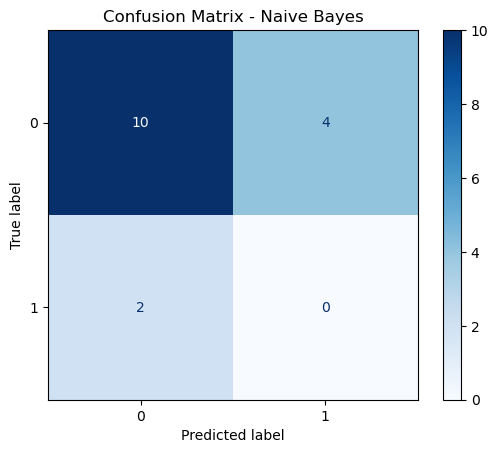

--- Gradient Boosting ---
Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        14
           1       0.00      0.00      0.00         2

    accuracy                           0.75        16
   macro avg       0.43      0.43      0.43        16
weighted avg       0.75      0.75      0.75        16



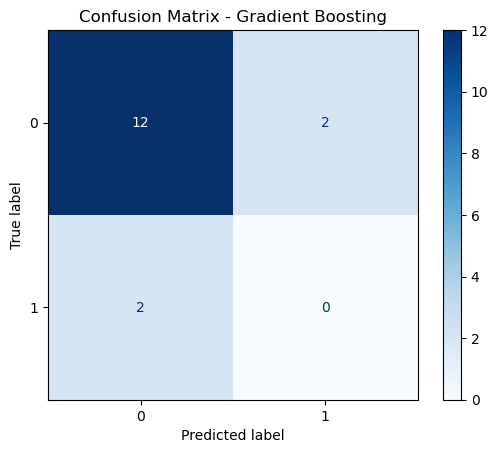

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Models to try
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

# Load the preprocessed dataset
df = pd.read_csv(r"C:\Users\91910\SLE_preprocessed.csv")

# Binary target creation
threshold = 10
df['target'] = df['Classification Score'].apply(lambda x: 1 if x > threshold else 0)
target_col = 'target'

# Encode categorical variables
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Prepare features and target
X = df.drop(columns=[target_col, 'Classification Score', 'RA'], axis=1)
y = df[target_col]

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Define models to evaluate
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=500),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"--- {name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {name}')
    plt.show()


# Model comparison using ROC Curves

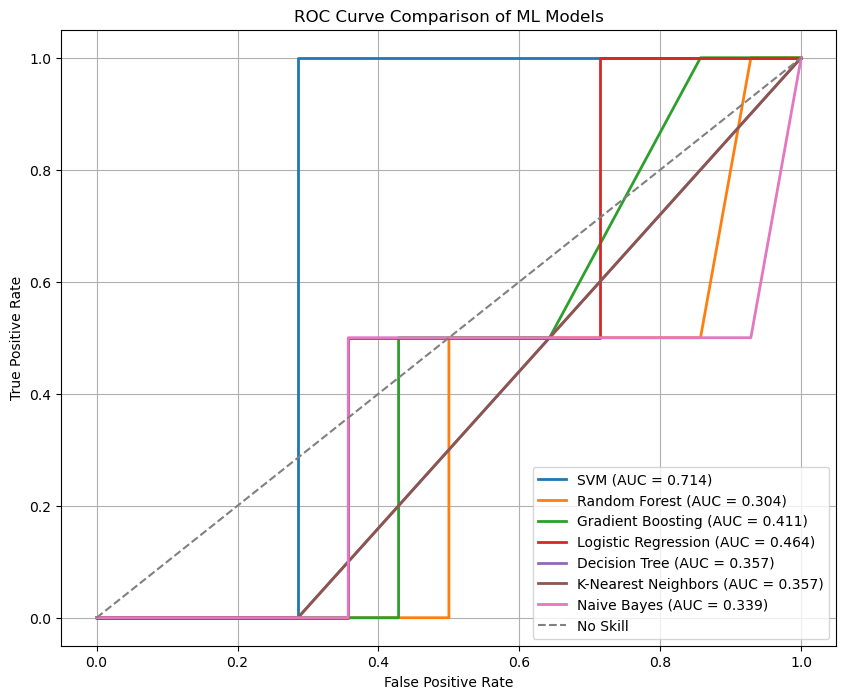

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Load the preprocessed dataset
df = pd.read_csv(r"C:\Users\91910\SLE_preprocessed.csv")

# Binary target
threshold = 10
df['target'] = df['Classification Score'].apply(lambda x: 1 if x > threshold else 0)
target_col = 'target'

# Encode categorical variables
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Prepare features and target
X = df.drop(columns=[target_col, 'Classification Score', 'RA'], axis=1)
y = df[target_col]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Define all models
models = {
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=500),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

plt.figure(figsize=(10, 8))

# Plot ROC curve for each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probability for positive class
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc_score:.3f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='No Skill')

plt.title('ROC Curve Comparison of ML Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# Model comparison based on accuracy

SVM Accuracy: 0.8750
Random Forest Accuracy: 0.8125
Logistic Regression Accuracy: 0.7500
Decision Tree Accuracy: 0.6250
K-Nearest Neighbors Accuracy: 0.8125
Naive Bayes Accuracy: 0.6250
Gradient Boosting Accuracy: 0.7500


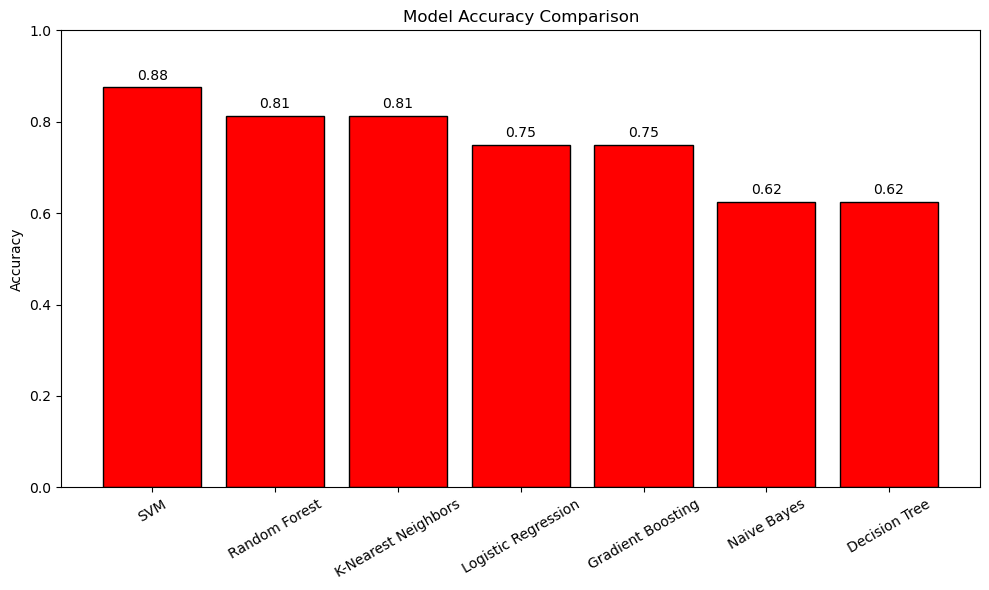

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC

# Load data
df = pd.read_csv(r"C:\Users\91910\SLE_preprocessed.csv")

threshold = 10
df['target'] = df['Classification Score'].apply(lambda x: 1 if x > threshold else 0)
target_col = 'target'

# Encode categorical
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop(columns=[target_col, 'Classification Score', 'RA'], axis=1)
y = df[target_col]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

models = {
    "SVM": SVC(kernel='rbf', random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=500),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

accuracies = []
model_names = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    model_names.append(name)
    print(f"{name} Accuracy: {acc:.4f}")

# Sort models by descending accuracy
sorted_pairs = sorted(zip(accuracies, model_names), reverse=True)
accuracies_sorted, model_names_sorted = zip(*sorted_pairs)

plt.figure(figsize=(10,6))
bars = plt.bar(model_names_sorted, accuracies_sorted, color='red', edgecolor='black')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=30)

# Annotate accuracy values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
